

```
# Approximate Nearest Neighbors:

# Image Recommendation System via Collaborative Filtering
```



# ***Please read the instructions very carefully***
This is a modified version of the previous question and requires you to use an artificial nearest neighbors library

We suggest you to use one of the following:
- [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy.git)

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   ⚠️ The Assignment will be evaluated automatically. Please adhere to taking proper inputs from `config.csv` file. You can change your `config.csv` file to experiment with your code. But at the end, make sure that your outputs are corresponding to input values in `config.csv`
5.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

## About the Dataset
Behance is a community art website where users showcase and discover creative work. Each user is able to “appreciate” (equivalent to a “like” on Instagram or a “react” on Facebook) an image, indicating that they like the image. It is in the website’s best interests to show users pictures that they would like, to keep them engaged for longer. For this question, given a set of pictures that a user has already appreciated, you have to show them a new picture that they would like based on what similar users appreciated.


<br><br>
**The dataset has information of 1 million appreciates of 63,497 users on 178,788 items. The file Behance appreciate 1M has a triplet in each line in the form of (user id, item id, unix timestamp).**

**Task: Take the inputs from the config.csv file and output the recommendations for a particular person**
- Collaborative Filtering is a way to predict items to the user based on the the
user’s history and the history of similar users. The similarity between users can be quantified by the number of images that both the users appreciated.
- The images appreciated by a similar user would be the most suitable images to show a user. Since we can find the similarity between any two users, we would be able to find the “nearest” neighbours of any user, allowing us to use a KNN-based algorithm to recommend new images to a user.
- Since people do not like seeing pictures that they have seen already. Make sure that you do not recommend pictures that a user has appreciated already.
- Output the final response will be saved in the file named ```config['output_file']```.


**Output file format:**
Populate the output file with images that the user has not seen of the k most
similar users, in descending order of their similarity. Each line in the output
file should be a duplet in the form of (item id, user id), where the user id is the
id of the kth similar user. The order of the images corresponding to the same
similar user would not matter. The output file would look something like this:
```
item_id_1_of_1st_similar_user 1st_most_similar_user_id
item_id_2_of_1st_similar_user 1st_most_similar_user_id
item_id_3_of_1st_similar_user 1st_most_similar_user_id
...
item_id_1_of_2nd_similar_user 2nd_most_similar_user_id
item_id_2_of_2nd_similar_user 2nd_most_similar_user_id
item_id_3_of_2nd_similar_user 2nd_most_similar_user_id
...
item_id_1_of_kth_similar_user kth_most_similar_user_id
item_id_2_of_kth_similar_user kth_most_similar_user_id
item_id_3_of_kth_similar_user kth_most_similar_user_id
```

You may use any other recommendation system that you wish to use. However,
evaluation script will score your submission by measuring the similarity between
users with the number of common images they appreciated.
The dataset was extracted using Behance’s API as a part of the paper
“Vista: A visually, socially, and temporally-aware model for artistic
recommendation, RecSys, 2016”. Check out this [Google Drive folder](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA) for
more information about the dataset.


Have fun! The users are waiting to see new pictures!

In [81]:
!pip install scann

In [82]:
import numpy as np
import pandas as pd
from heapq import heapify, heappush, heappop
from sklearn.decomposition import TruncatedSVD as tsvd
import scann

In [83]:
config = pd.read_csv('config.csv').iloc[0]

user = int(config['id'])
k_value = int(config['k'])

In [84]:
data_df = pd.read_csv(config['dataset_file'], delimiter=' ')
data_df.columns = ['user_ids', 'image_ids', 'timpstamp']

In [85]:
all_images = set()
user_likes = dict()

In [86]:
usr = []
imgs = []
vals = []
for row in data_df.values:
    # usr.append(user_ids_index[row[0]])
    # imgs.append(image_ids_index[row[1]])
    # vals.append(1)
    if row[0] not in user_likes:
        user_likes[row[0]] = set()
    user_likes[row[0]].add(row[1])
    all_images.add(row[1])

In [87]:
all_users = list(user_likes.keys())

In [88]:
# user_ids = data_df['user_ids'].unique()
user_ids_index = dict()
# image_ids = data_df['image_ids'].unique()
image_ids_index = dict()

In [89]:
i = 0
for user_id in user_likes.keys():
    user_ids_index[user_id] = i
    i += 1

i = 0
for img_id in all_images:
    image_ids_index[img_id] = i
    i += 1

In [90]:
for row in data_df.values:
    usr.append(user_ids_index[row[0]])
    imgs.append(image_ids_index[row[1]])
    vals.append(1)


In [91]:
from scipy.sparse import csr_matrix

In [92]:
sparse_matrix = csr_matrix((vals, (usr, imgs)))

In [93]:
# sparse_matrix[]

no of components value = 1000, value found after experimentation with different values

random_state = 17, any value to get the same result

In [94]:
svd = tsvd(n_components=1000, random_state=17)
matrix = svd.fit_transform(sparse_matrix)

Scann algo requires normalised data

In [95]:
normalized_dataset = matrix / np.linalg.norm(matrix, axis=1)[:, np.newaxis]

In [96]:
import math

In [97]:
def prod(iter):
    a = 1
    for i in iter:
        a *= i
    return a

In [98]:
# leaves = math.ceil(math.sqrt(prod(matrix.shape)))

In [101]:
leaves = math.ceil(math.sqrt(matrix.shape[0]))

num_leaves is an important parameter and the scann algo gives best results when it has sqrt(n) value, n being size of matrix. 

training_sample_size is the no. of users

reorder = 100, since scann gives best results when, after the raw search, top k values extracted and are then reordered. 100 is used since it is most used as a value when reordering occurs

score_ah - "Unless near-perfect accuracy is required, AH gives better speed/accuracy tradeoffs", as written in scann docs. Value taken from the docs.

In [102]:
searcher = scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product").tree(
    num_leaves=leaves, num_leaves_to_search=100, training_sample_size=matrix.shape[0]).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [103]:
neighbors, distances = searcher.search(matrix[user_ids_index[user]], final_num_neighbors=k_value+3)

In [104]:
distances

array([1.7902029, 1.0048845, 1.0031675, 1.0027201, 1.0011166, 1.0005428,
       1.0005053, 1.0005053], dtype=float32)

In [105]:
ans = [all_users[t] for t in neighbors]

In [106]:
ans

[15341, 702030, 1697089, 3877752, 517645, 1877166, 2935101, 1354204]

In [107]:
matrix.shape

(63497, 1000)

In [108]:
outFile = open(config['output_file'], 'w')

sol_item_set = set()
no_users = 0
for user_id in ans:
    new_user = True
    for item_id in user_likes[user_id]:
        if item_id not in user_likes[user] and item_id not in sol_item_set:
            if new_user:
                no_users += 1
                new_user = False
            if no_users > k_value:
                break
            sol_item_set.add(item_id)
            outFile.write(str(item_id) + ' ' + str(user_id) + '\n')
print(no_users)
outFile.close()

5


In [109]:
# def neighbors(user, k_value):
#     global user_likes
#     user_img_id_set = user_likes[user]
#     jcc_heap = []
#     corr_heap = []
#     heapify(jcc_heap)
#     heapify(corr_heap)
    
#     for some_user,img_id_set in user_likes.items():
#         if some_user == user:
#             continue
#         #calculating jaccard index
#         jcc_ind = len(img_id_set.intersection(user_img_id_set))/len(img_id_set.union(user_img_id_set))
#         heappush(jcc_heap, (jcc_ind, some_user))
#         # no_of_common_img = len(img_id_set.intersection(user_img_id_set))
#         # heappush(jcc_heap, (no_of_common_img, some_user))
#         if(len(jcc_heap) > k_value):
#             heappop(jcc_heap)
    
#     for i in range(len(corr_user)):
#         if(user == user_image_likes_ids[i]):
#             continue
#         heappush(corr_heap, (corr_user[i], i))
#         if(len(corr_heap) > k_value):
#             heappop(corr_heap)
#     jcc_users = [user_ for val, user_ in jcc_heap]
#     svd_min_users = [user_image_likes_ids[i] for val, i in corr_heap]
#     print(jcc_users)
#     print('No. of common users between jaccard method and correlation vector method')
#     print(set(jcc_users).intersection(set(svd_min_users)))

#     return [user_image_likes_ids[t[1]] for t in sorted(corr_heap, key=lambda x: -x[0])]

# Q1. Explain how your choice of library works

A1. The popular seach technique is the Embedding-based search. In this technique ML models are trained to map the queries and data items to a common vector embedding space, such that the distance between the different embeddings carries semantic meaning, which basically means similar items are closer together. This technique is effective at answering queries that rely on semantic understanding of the query rather than simple indexable properties.
The system maps all queries to their respective embedding spaces, and then finds, among all these embeddings, the ones closest to one query. Such a technique is called Nearest Neighbour Search problem. 

One of the most common way to define the query-database embedding similarity is be their inner product (or dot product), and is known to be the Maximum Inner-Product Search (MIPS). This is often the computational bottleneck to infer speed of a computation since the dataset size can easily be in the millions or billions, thus making the exhaustive search impractical. 

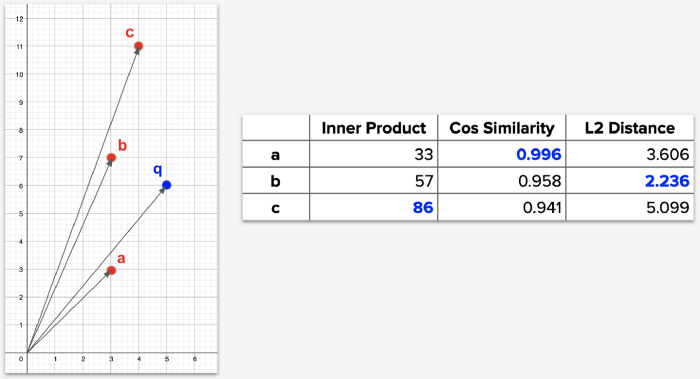

Intuitively, vector a or b is the closest or similar to the query vector q in the figure above, but vector c is the similar vector based on inner product maximization. ScaNN was developed for MIPS

Vector Quantization in ScaNN
There are 2 major findings in the ScaNN vector quantization.

**Score Aware Loss**: 

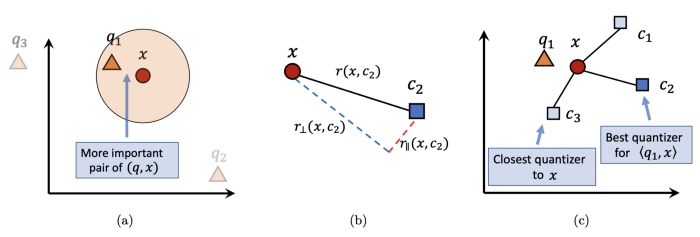

Not all pairs of q and x are equally important. For x, it is more important to accurately quantize the inner product of <q1, x> than <q2, x> or <q3, x>.

**Anisotropic Loss**: Quantization error can be decomposed to parallel component and orthogonal component. And the parallel component penalizes more than the orthogonal component.

Standard vector quantization is not very practical for high dimensional or large scale databases. PQ (product quantization) is a widely used scalable vector quantization method.

**ScaNN also uses PQ, so we can say ScaNN is that PQ with score aware loss and anisotropic loss.**

ScaNN (Scalable Nearest Neighbors) is the library which provies method for 
efficient vector similarity search at scale. This includes search space pruning
 and quantization for Maximum Inner Product Search and also supports other 
distance functions such as Euclidean distance. 

#### Q2. **Compare your choice of library with vanilla KNN.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

Time complexity of vanilla KNN - O(nxd)

#### Q3. **Compare your choice of library with implementation of ScaNN, faiss and annoy.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***



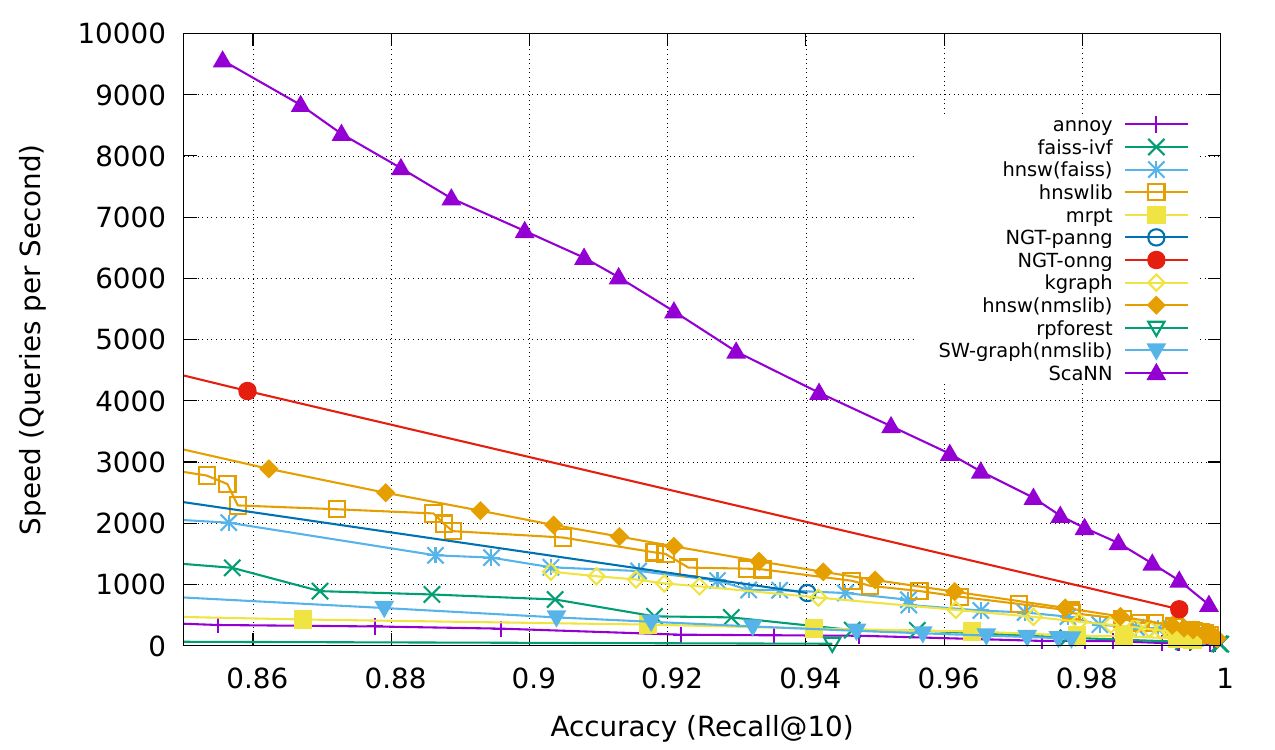